#  Fraud Detection

## Goal: 

The goal of this challenge is to build a machine learning model that **predicts the probability** that
the first transaction of a new user is **fraudulent**.

## Data

We have 2 tables for this challenge:

**Fraud_Data** - information about each user's first transaction

**Columns:**

- **user_id** : Id of the user. Unique by user

- **signup_time** : the time when the user created her account (GMT time)

- **purchase_time** : the time when the user bought the item (GMT time)

- **purchase_value** : the cost of the item purchased (USD)

- **device_id** : the device id. You can assume that it is unique by device. I.e., transaJtions with the same device ID means that the same physical device was used to buy

- **source** : user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typingthe site address on the browser).

- **browser** : the browser used by the user.
- **sex** : user sex: Male/Female
- **age** : user age
- **ip_address** : user numeric ip address
- **class** : this is what we are trying to predict: whether the activity was fraudulent (1) or not (0).


**IpAddress_to_Country** - mapping each numeric ip address to its country.
For each country, it gives a range. If the numeric ip address falls within
the range, then the ip address belongs to the corresponding country.

**Columns:**

- **lower_bound_ip_address** : the lower bound of the numeric ip address for that country
- **upper_bound_ip_address** : the upper bound of the numeric ip address for that country
- **country** : the corresponding country. If a user has an ip address whose value is within
the upper and lower bound, then she is based in this country

### Import dependencies

In [1]:
# Import main libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import Classifiers 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, partial_dependence
from sklearn.ensemble.partial_dependence import plot_partial_dependence

from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
# Import Model Evaluation tools
from sklearn.model_selection import train_test_split

In [4]:
# Import Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_curve

In [5]:
# Import preprocessing tools
from sklearn.preprocessing import LabelEncoder, imputation, StandardScaler

### Read in the data

In [6]:
# Read in the data
fraud_data = pd.read_csv('fraud_data.csv')
ip_address = pd.read_csv('IpAddress_to_Country.csv')

In [7]:
#Comparing the two tables
len(fraud_data) == len(ip_address)

False

Number of rows for the tables are different

In [8]:
len(fraud_data) == len(fraud_data.user_id) #all users are unique

True

 Create a loop to look up the country from IP address range and insert a new column 'country' in the main dataset. If the IP address is not falling inside a specific range, no country will be looked up and the corrispondent value will remain set to '0'. Therefore we have to expect some '0' in this column

In [9]:
# country = len(fraud_data) * [0]
# for ind, row in fraud_data.iterrows():
#     temp = ip_address[(ip_address['lower_bound_ip_address'] < row['ip_address']) & 
#            (ip_address['upper_bound_ip_address'] > row['ip_address'])]['country']
#     
#     if len(temp) == 1:
#         country[ind] = temp.values[0]
# fraud_data['country'] = country

In [10]:
# Create a new csv file with country to save time each time we run the kernel
#fraud_data.to_csv('full_data.csv')

In [11]:
# Read in the new table with country in a new dataframe called data
data = pd.read_csv('full_data.csv', parse_dates=['signup_time', 'purchase_time']) # parse the time columns

### Explore the dataset

In [12]:
# Check first 5 rows of the dataframe to get a sense of the data
data.head() 

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Column **Unnamed:0** to be removed from the dataframe being an incorrect index

In [13]:
data = data.drop('Unnamed: 0', axis=1)

In [14]:
#Check data structure ( types, missing values, etc.)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           151112 non-null object
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 13.8+ MB


In [15]:
#determine the number of frauds in the dataset
fraud = data[data['class']==1]
valid = data[data['class']==0]
print('Fraud cases: {}'.format(len(fraud)))
print('Valid cases: {}'.format(len(valid)))
print('% of frauds = ', round((data['class'].mean()*100),2))

Fraud cases: 14151
Valid cases: 136961
% of frauds =  9.36


From the data above we can see that the dataset does not show unbalanced classes behavior, therefore is it safe to assume that a Supervised Learning model can perform well.

###### Sanity check of data

In [16]:
data.source.unique() # Ok only three sources

array(['SEO', 'Ads', 'Direct'], dtype=object)

In [17]:
data['country'].nunique()

182

In [18]:
data.sex.unique() # Ok only two sex

array(['M', 'F'], dtype=object)

In [19]:
data.browser.unique()

array(['Chrome', 'Opera', 'Safari', 'IE', 'FireFox'], dtype=object)

In [20]:
np.sort(data.age.unique()) # OK ages are reasonable

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 76], dtype=int64)

In [21]:
data['class'].unique() # OK only two classes: frauds and legit transactions

array([0, 1], dtype=int64)

 Data appear all admissible. No further action requested as data cleaning

# FEATURES ENGINEERING

In [22]:
#Difference between signup time and purchase time
data['diff_time'] = (data['purchase_time'] - data['signup_time'])/np.timedelta64(1, 's')

In [23]:
# Different user id's using the same device (many different user ids using the same device could be an indicator of fake accounts)
data['device_user_count'] = data.groupby('device_id')['user_id'].transform('count')

In [24]:
# Number of users' using a given ip address. Many different users having the same ip address could be an indicator of fake accounts
data['ip_count'] = data.groupby('ip_address')['user_id'].transform('count')

We might expect these last two features to be highly correlated, in case of fraudolent activities. Therefore, should we decide
to use some linear model, one of the two should be dropped. On the contrary, using some kind of tree-based model, we will not have to 
worry about it, because the model will take care of this problem, just ignoring one of the two variables.

In [25]:
# sign_up day of the week
data['signup_time_wd'] = data.signup_time.dt.dayofweek

In [26]:
# sign_up week of the year
data['signup_time_wy'] = data.signup_time.dt.weekofyear

In [27]:
# Explore modified data structure
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,diff_time,device_user_count,ip_count,signup_time_wd,signup_time_wy
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1,1,9
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1,6,23
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0,492085.0,1,1,1,18
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1,1,30


In [28]:
np.sort(data['country']) # country column as expected contains some '0' values

array(['0', '0', '0', ..., 'Zimbabwe', 'Zimbabwe', 'Zimbabwe'],
      dtype=object)

In [29]:
data['country'] =data['country'].replace('0', 'Not Found') #Replace 0 in countries with 'Not Found'

In [30]:
#Keep only the top 50 countries
#Replace everything else with 'Other'
top_50 = list(data.groupby('country')[['user_id']].count().sort_values('user_id', ascending = False).index)[0:50]
top_50 =top_50[0:1] + top_50[2:] # remove not found from the list

In [31]:
data['country_revised'] = np.where(data['country'].isin(top_50), data.country, 'other')

### Data processing for Machine Learning Analysis

We now process the dataset in order to feed the data to the ML model we are going to select. 

######  Create Feature Matrix X

In [32]:
#slice the dataframe dropping all useless columns and class series
X = data.drop(['user_id', 'signup_time','purchase_time','class', 'device_id', 'country', 'ip_address'], axis = 1).copy()
X.shape

(151112, 11)

###### Label encoding of categorical features

In [33]:
lb = LabelEncoder() # instantiate the encoder
for feature in X.select_dtypes(include = ['O']).columns.values: # loop through all the feature spaces and pick only the categorical variables
    X[feature]= lb.fit_transform(X[feature])

In [34]:
X.info() # final check on feature matrix X values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
purchase_value       151112 non-null int64
source               151112 non-null int64
browser              151112 non-null int64
sex                  151112 non-null int64
age                  151112 non-null int64
diff_time            151112 non-null float64
device_user_count    151112 non-null int64
ip_count             151112 non-null int64
signup_time_wd       151112 non-null int64
signup_time_wy       151112 non-null int64
country_revised      151112 non-null int64
dtypes: float64(1), int64(10)
memory usage: 12.7 MB


Feature matrix full of numeric values only and showing no presence of missing values. Ready for manipulation

In [35]:
#Explore the feature matrix processed to be fed to a ML model
X.head()

,purchase_value,source,browser,sex,age,diff_time,device_user_count,ip_count,signup_time_wd,signup_time_wy,country_revised
0,34,2,0,1,39,4506682.0,1,1,1,9,25
1,16,0,0,0,53,17944.0,1,1,6,23,46
2,15,2,3,1,53,1.0,12,12,3,1,46
3,44,2,4,1,41,492085.0,1,1,1,18,49
4,39,0,4,1,45,4361461.0,1,1,1,30,46


###### Create response vector y

In [36]:
#Response Variable
y = data['class']

### Cross validation

In [37]:
# split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

###### RANDOM FOREST

In [38]:
#instantiate the model
rf = RandomForestClassifier(n_estimators=100, # to speed up process time and obtain acceptable results
                            n_jobs=-1,        # to exploit all cores
                            random_state=23,  # for reproducibility
                            oob_score=True)  # to exploit internal cross validation tool of RF classifier

In [39]:
# train the model
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=23, verbose=0, warm_start=False)

In [40]:
# calculate the accuracy of the model on training set
training_accuracy = rf.score(X_train, y_train) 
print('Accuracy of Training set = {:.5f}'.format(training_accuracy))

Accuracy of Training set = 0.99998


Training accuracy is very high, no chance of underfitting, hence we can be sure the model is no biased

In [41]:
print('Cross Validation accuracy = {:.5f}'.format(rf.oob_score_))

Cross Validation accuracy = 0.95579


Cross validation accuracy is very close to training accuracy, hence the model is no overfitting

In [42]:
# predict conversion rate on unseen data X_test
y_pred = rf.predict(X_test)
test_score = rf.score(X_test, y_test)
print('Testing Accuracy = {:.5f}'.format(test_score))

Testing Accuracy = 0.95719


The model seems to have a high acccuracy, but we first of all have to compare it with so-called nulled accuracy, which is the most predicted class percentage. For a binary classification can be easily calculated as:

In [43]:
Null_Accuracy = max(y_test.mean(), 1-y_test.mean()) 
print('Null Accuracy= {:.4f}'.format (Null_Accuracy)) # Baseline for model evaluation

Null Accuracy= 0.9070


Random Forest Model with no parameter optimization have a slighly higher accuracy than a dummy regressor, but due to the high class imbalance we have to bring onto the table other metrics to better evaluate model performance, namely:precision, recall, roc_auc score

In [44]:
print('Classification Report=\n\n',(classification_report(y_test, y_pred)))

Classification Report=

              precision    recall  f1-score   support

          0       0.96      1.00      0.98     45231
          1       0.99      0.54      0.70      4636

avg / total       0.96      0.96      0.95     49867



In [45]:
print('Confusion Matrix =\n\n',confusion_matrix(y_test, y_pred))

Confusion Matrix =

 [[45206    25]
 [ 2110  2526]]


**Recall of the model is 0.54**. That means the model is able to catch only 54% of frauds, in fact 2110 fraudulent operations, are not correctly classified such as by the model. These are the False Negative (**FN**) errors of the model

**Precision of the model is 0.99**. The model is correct in classifying frauds 98% of the times whenever predicting frauds: only 25 transactions labelled as fraud are, in fact, legit operations. These are the False Positive (**FP**) errors of the model.

Recall's model is insufficient. Must be risen, even at cost of losing in precision. A ROC analysis can help to improve threshold fixed bydefault at 0.5

### ROC analysis

In [46]:
# Calculate class predicted probability
prob_score = rf.predict_proba(X_test)
prob_score[:,1]

array([0.03, 0.02, 0.05, ..., 0.01, 0.  , 0.  ])

In [47]:
rf_roc_auc = roc_auc_score(y_test, prob_score[:,1])
print ("Random Forest AUC = %.4f" % rf_roc_auc)

Random Forest AUC = 0.8486


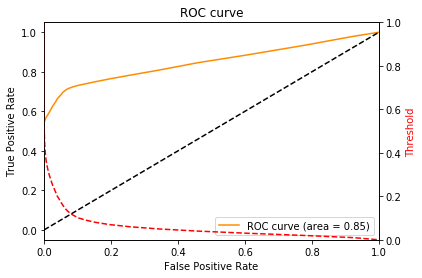

In [48]:
#Plotting the ROC curve
fpr,tpr,thresholds = roc_curve(y_test, prob_score[:,1])
plt.plot(fpr,tpr, color = 'darkorange', label='ROC curve (area = %0.2f)' % (rf_roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('roc_and_threshold.png')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]]);

In [49]:
# Optimize threshold to increase Recall
i = np.arange(len(fpr))
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 
                    'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc['tf']-0).abs().argsort()[[0]]]

,1-fpr,fpr,tf,thresholds,tpr
59,0.744047,0.255953,0.038524,0.06,0.782571


###### Rebuilding the random forest model reducing threshold to classify class 1 as low as 0.06

In [50]:
prob = rf.predict_proba(X_test)[:,1]
prob[prob > 0.06] = 1
prob[prob <= 0.06] = 0

In [51]:
print (classification_report(y_test, prob))

             precision    recall  f1-score   support

          0       0.97      0.80      0.88     45231
          1       0.29      0.76      0.42      4636

avg / total       0.91      0.80      0.84     49867



In [52]:
print (confusion_matrix(y_test, prob))

[[36401  8830]
 [ 1095  3541]]


In [53]:
rf_roc_auc = roc_auc_score(y_test, prob)
print ("Random Forest AUC = %.4f" % rf_roc_auc)

Random Forest AUC = 0.7843


**Recall went up to 76%**. Lowering the threshold allowed the model to catch ca 3/4 of the frauds. Now only 1095 frauds go trough undetected.

This, though, happened at the expenses of **Precision which went down to 0.29**. Now 8830 legit transactions of the test set are labelled as frauds.

# MODEL INSIGHTS

Utilize feature importances attributes automatically generated by the model to rank the importance of all features

In [54]:
rf.feature_importances_

array([0.08106175, 0.01342592, 0.02426769, 0.00971388, 0.06971126,
       0.34278045, 0.11750686, 0.15985537, 0.03422282, 0.10279093,
       0.04466307])

In [55]:
#zip the array and sort it
for feature in sorted(list(zip(rf.feature_importances_, X)), reverse=True):
    print(feature)

(0.34278044933826074, 'diff_time')
(0.15985536627312413, 'ip_count')
(0.11750686455048998, 'device_user_count')
(0.10279092913393617, 'signup_time_wy')
(0.081061750355284, 'purchase_value')
(0.06971125904412155, 'age')
(0.04466307325983911, 'country_revised')
(0.034222822565797596, 'signup_time_wd')
(0.024267693303821124, 'browser')
(0.01342591589592548, 'source')
(0.009713876279400284, 'sex')


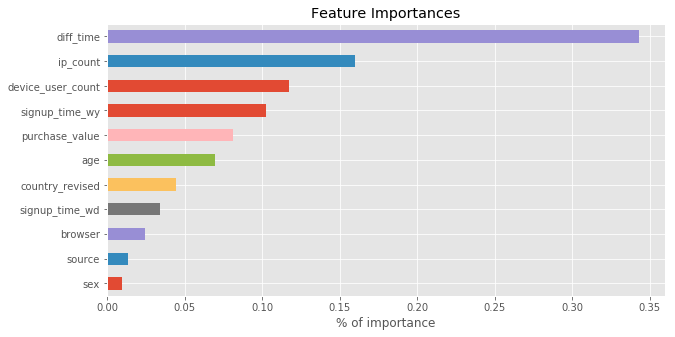

In [56]:
# plotting settings
plt.style.use("ggplot")
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh', figsize=(10,5))
plt.title('Feature Importances'), plt.xlabel('% of importance');

The most sensible predictors of fraudent behavior are the engineered feature 'diff time' and the number of 'ip count'. 
we can use a decision tree model to check the first 3/4 depths level and gain some insights

###### Decision Tree classifier

 Let’s now build a simple decision tree and check the 3 or 4 most important segments to confirm our conclusion, also to have a rough idea about discriminating values about the features we have identified as predictive

In [57]:
tree = DecisionTreeClassifier(random_state=0, criterion = 'entropy', max_depth = 4)
tree.fit(X, y)
export_graphviz(tree, out_file='tree.dot', feature_names=X.columns, class_names=[' legits', 'frauds'],
               impurity=False, filled=True, node_ids= True, proportion=False)

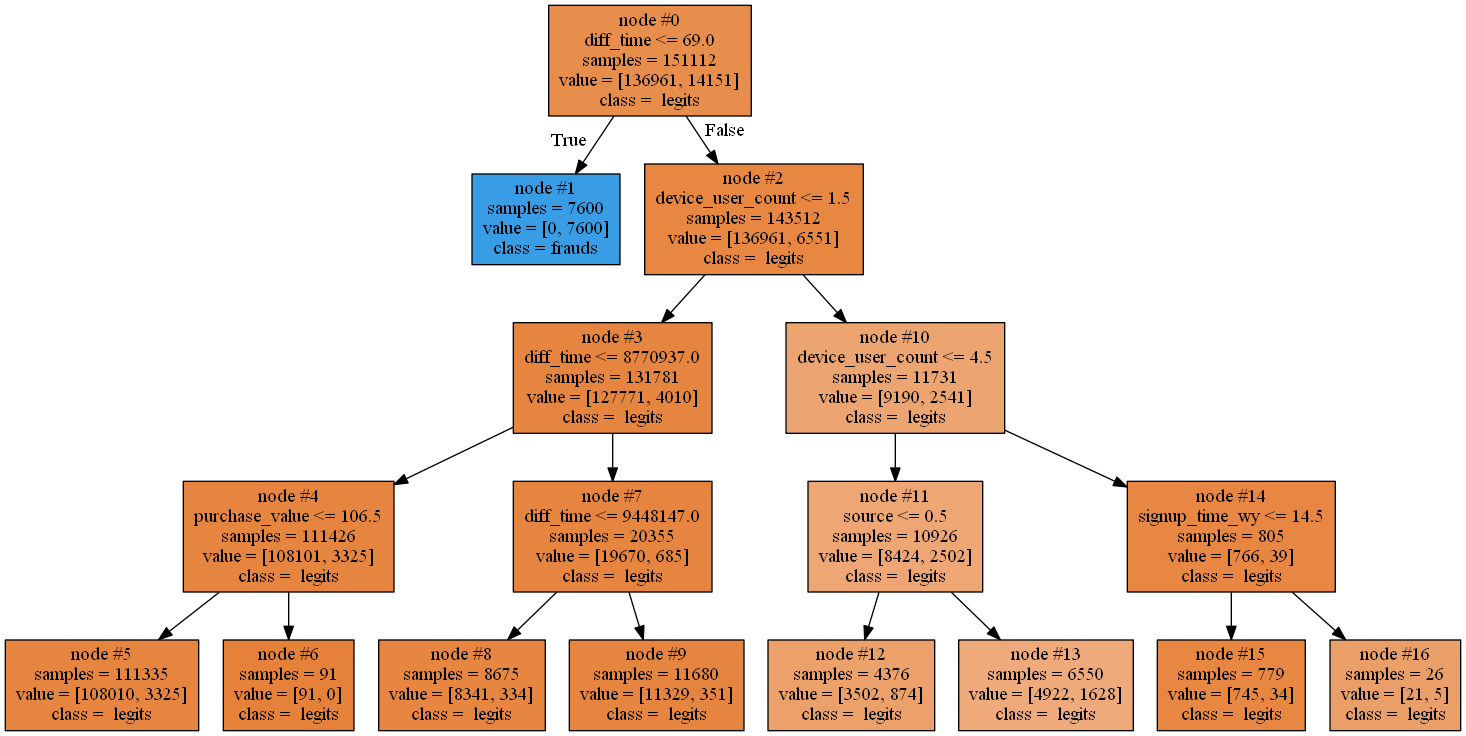

In [58]:
from IPython.display import Image
Image(filename='tree.png') 

 According to tree's splits, the most important variable is, by far, the difference time between sign up and first purchase.
 Whenever lesser than 70 seconds is an astonishing 100% fraud. No surprise, though, if matched with real life, considered that performing the
 first purchase should require some time to the user to get accustomed with the website. As high as half of the frauds lay inside this cluster.

 Among the remaining ones another consistent chunk of frauds is identified within those users, that, despite having only one IP and purchasing
 throug just a single device, within around three months, purchased something whose value is below the 106.5$.

 Numbers of device, Numbers of IP show a behaviour a bit unexpected. Most of the frauds performed by these categories are related to 
 users with 2-3-4 devices. We might have expected a very strong relation with higher numbers of devices.
 Among this bucket some influence seems to  be exerted by the source, with fraudsters landing on the site through Ads and Directs.


###### GRADIENT BOOSTING REGRESSION

Let's use gradient boosting classification model to exploit partial depende plot to confirm our insights

In [59]:
#instantiate the classifier
est =GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1,
                                           min_samples_leaf=3, 
                                          random_state=0)

In [60]:
#fit the data
est.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

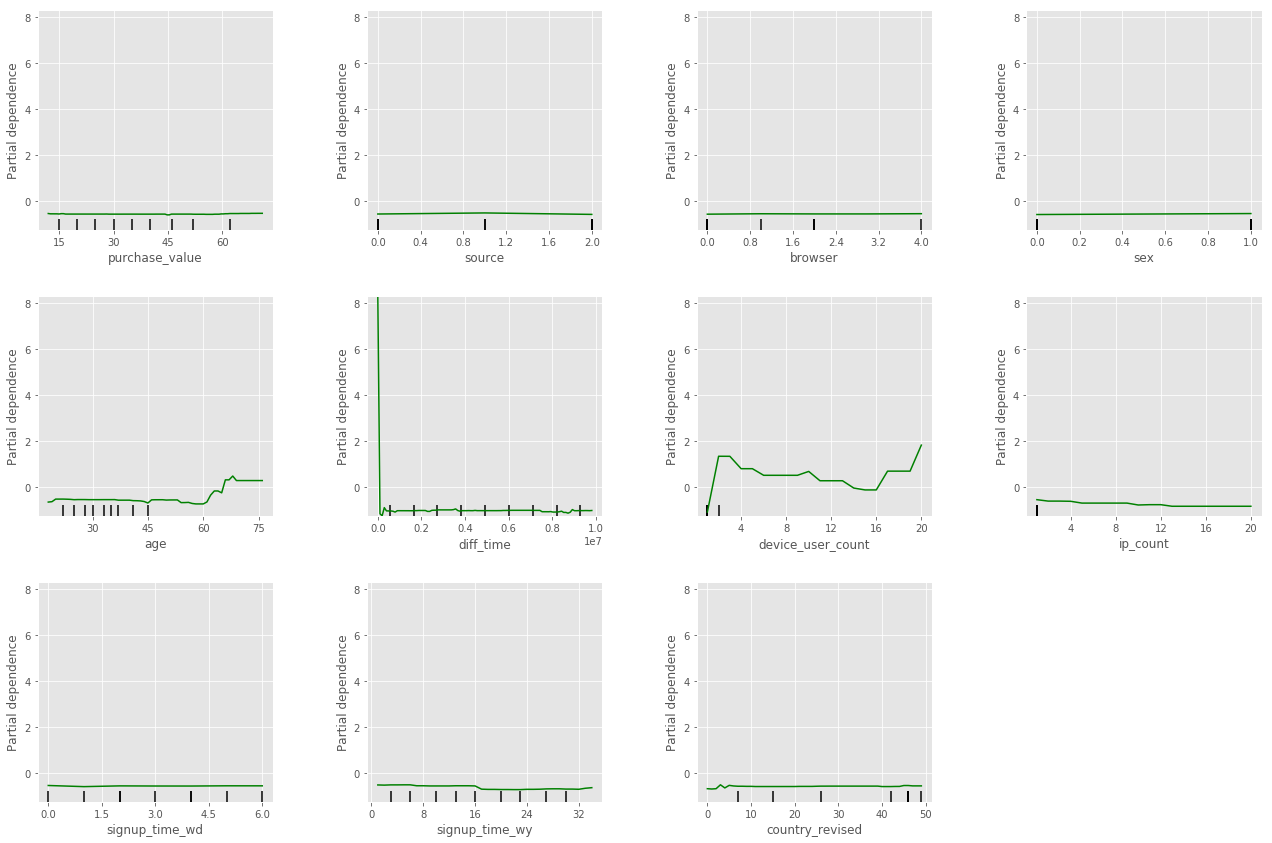

In [61]:
fig, ax = plot_partial_dependence(est, X_train, features=X_train.columns.values, feature_names=X.columns.values, 
                                   n_cols=4,figsize=(20,20) )

Once again the features we identified as predictive of the class confirm to be the same.

### Conclusions

We identified a model that assigns to each user a probability of committing a fraud. From a production point of view, though,   wewant to think about creating different experiences based on this predicted probability of committing fraud.

1. If **predicted fraud probability < T**, the user has the normal experience (the high majority should fall
here)


2. If **T <= predicted fraud probability < Z** (so the user is at risk, but not too much), you can create an
additional verification step, like verify your phone number via a code sent by SMS or log in via
Facebook.


3. If **predicted fraud probability >= Z** (so here is really likely the user is trying to commit a fraud), you
can tell the user his session has been put on hold, send this user info to someone who reviews it
manually and either blocks the user or decides it is not a fraud so the session is resumed.


# ANOMALY DETECTION

A more reliable technique to prevent frauds is anomaly detection. In this case, you define as fraud any
transaction having a pattern which is significantly different from legitimate transactions. That theoretically
solves most of the problems of a supervised learning approach, since you are not training your model on specific kinds of frauds, but
simply on different behavior. However, it suffers from its own limitations. For instance, in high dimension, you
are almost guaranteed that every transaction is an outlier on at least one dimension (curse of dimensionality),
so the anomaly detection approach requires a significant investment in terms of time to exactly define what
means being an anomaly. 
The dataset we analized in this example is not greatly unbalanced, then we could expect a decent prediction power. Let' approach the problem from an anomaly detection point of view and compare the results.

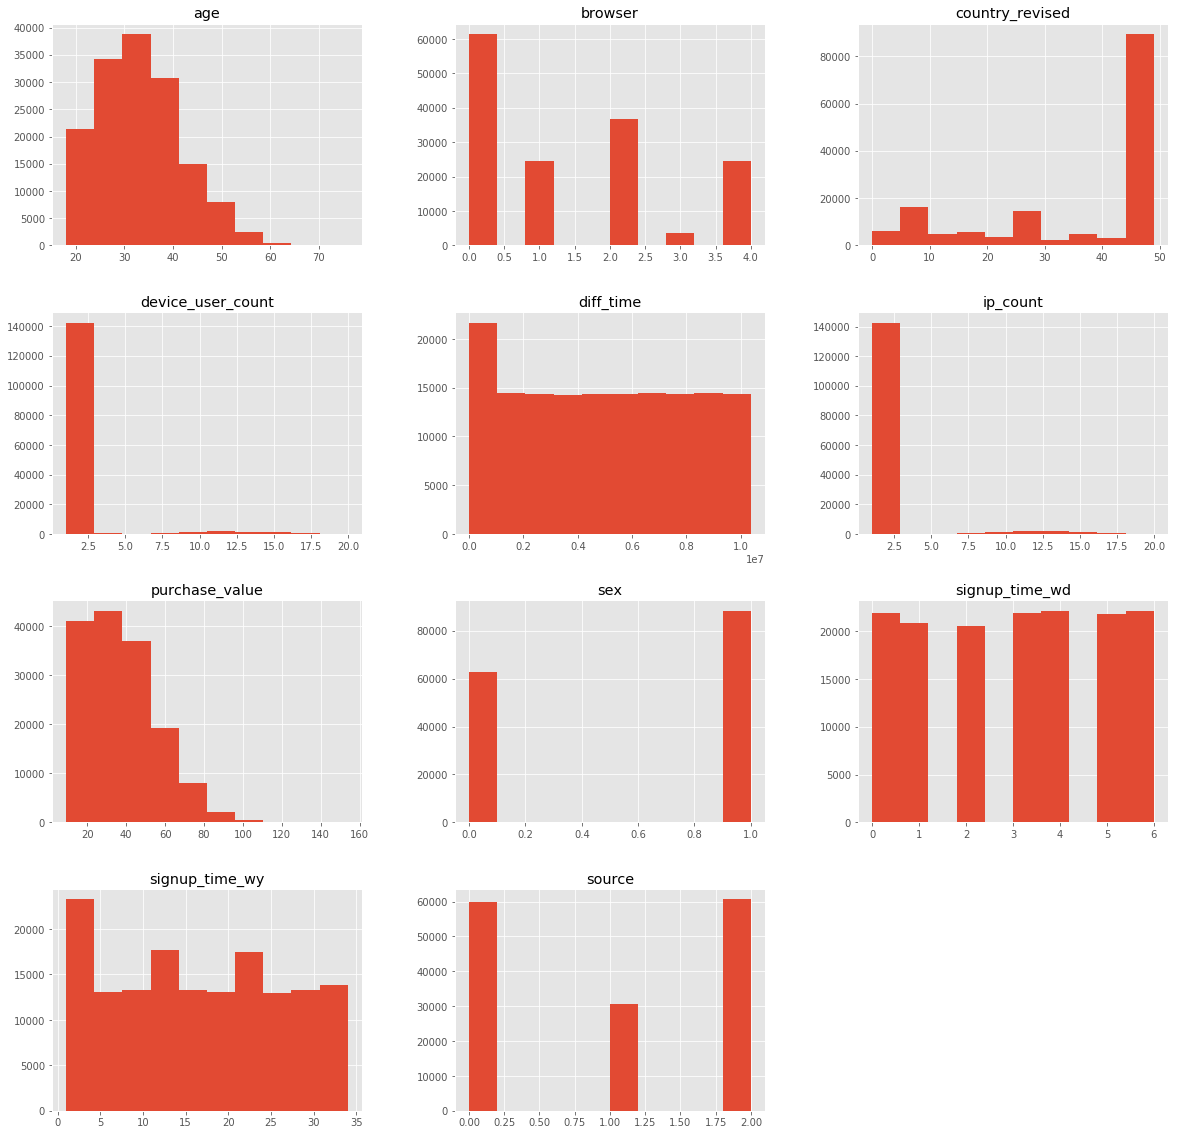

In [62]:
#plot histograms to explore features distributions
X.hist(figsize=(20,20))
plt.show();

In [63]:
#determine the number of outliers in the dataset
outlier_fraction = len(fraud)/float((len(valid)))
print('Fraction of outlier: {:.4f}'.format(outlier_fraction))

Fraction of outlier: 0.1033


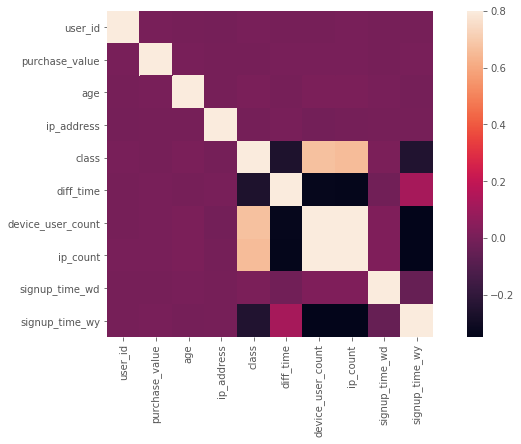

In [64]:
#correlation matrix, check the existence of strong correlation between variables
corrmat = data.corr()
fig = plt.figure(figsize=(12,6))
sns.heatmap(corrmat, square=True, vmax=0.8);

In [65]:
# Import anomaly detection common classifiers
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Import accuracy score metrics
from sklearn.metrics import accuracy_score

In [66]:
# define the outlier detection method
classifiers = {
    "Isolation forest": IsolationForest(max_samples=len(X),
                                       contamination= outlier_fraction,
                                       n_jobs=-1,
                                       random_state= 23),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20,
                                              contamination= outlier_fraction)
    
}

In [67]:
#fit the model
n_outliers = len(fraud)
for i, (clf_name, clf) in enumerate(classifiers.items()): # enumerate to loop through classifiers and extraxcting from dictionary
    
    #fix the data and tag  outliers
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
     
    # reshape the prediction values 0 for legit, 1 for fraud
    y_pred[y_pred==1] = 0
    y_pred[y_pred==-1] = 1
    n_errors = (y_pred !=y).sum()

    # run the classification matrix
    print('Model {}:\nn_errors= {}\n'.format(clf_name, n_errors) )
    print('Accuracy score= {:.4f}\n'.format(accuracy_score(y, y_pred)))
    #print('Classification report:{}\n\n'.format(classification_report(y, y_pred)))
    print('Classification Report:\n\n',(classification_report(y, y_pred)))
    # print the confusion matrix
    print('Confusion Matrix:\n ')
    print((confusion_matrix(y, y_pred)))
    
    # print a new line for  readibility
    print('\n')    

Model Isolation forest:
n_errors= 14390

Accuracy score= 0.9048

Classification Report:

              precision    recall  f1-score   support

          0       0.95      0.94      0.95    136961
          1       0.49      0.54      0.52     14151

avg / total       0.91      0.90      0.91    151112

Confusion Matrix:
 
[[129035   7926]
 [  6464   7687]]


Model Local Outlier Factor:
n_errors= 24336

Accuracy score= 0.8390

Classification Report:

              precision    recall  f1-score   support

          0       0.92      0.91      0.91    136961
          1       0.17      0.19      0.18     14151

avg / total       0.85      0.84      0.84    151112

Confusion Matrix:
 
[[124062  12899]
 [ 11437   2714]]




Anomaly detection models perform much worse than Supervised Learning algorithms. Even Isolation Forest performances are worse than basic RF. Due to the fact that dataset is not greatly unbalanced AD algorithms perform worst than Supervised Learning als.